<a href="https://colab.research.google.com/github/oublalkhalid/MoroccoAI-Data-Challenge/blob/main/training/Detect_Morocco_Plate_Licence_Flow_Normalizing_(Part_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

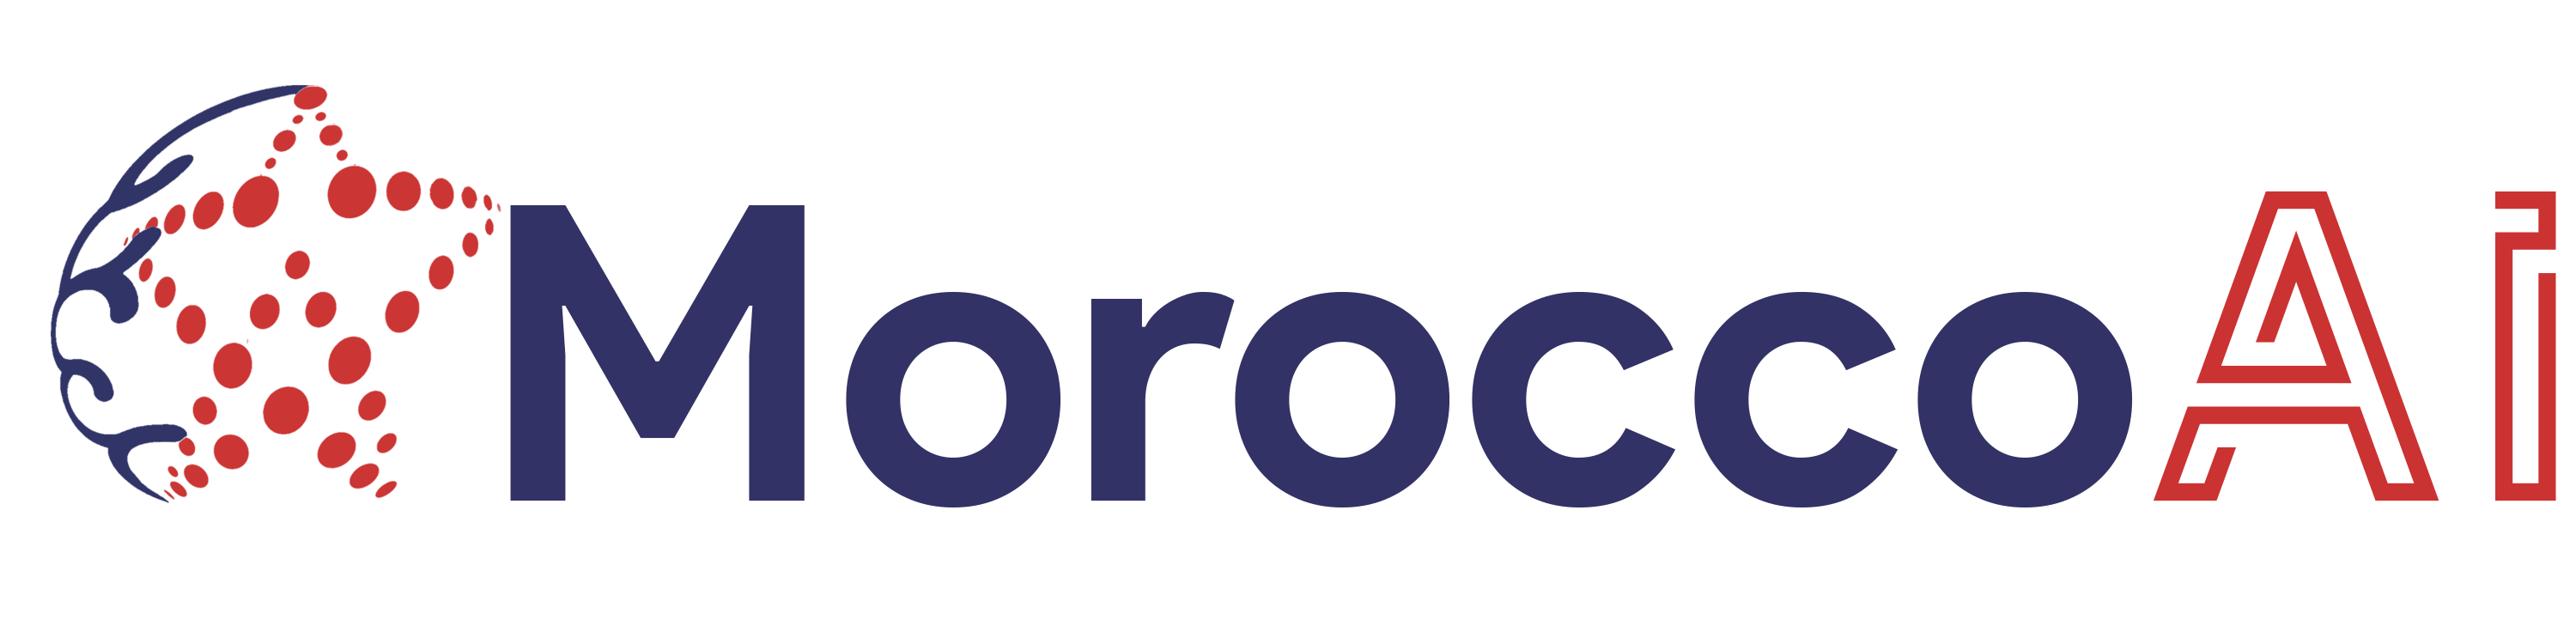

# DETECT MOROCCO PLATES LICENSES (Deep Neural Network: Flow Normalizing Part III)

> **Note:**
A large part of this work was done under an AI station with an RTX Geforce 3090 card. However, to facilitate the visualization of this approach, we made this notebook under Colab Pro (you can also run this code under Kaggle, or airflow).

### Connect to my drive to import data

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

### Create Sym link for easy access of my drive and Check connection

In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

### Copy LicensePlateRecognition data zip to Colab

In [ ]:
!ls /mydrive/LicensePlate
!cp /mydrive/LicensePlate/Dl_LicensePlateRecognition.zip ../


cnn_train.py  Dl_LicensePlateRecognition.zip


### Extracting zip to Colab machine under license folder

In [ ]:
!unzip ../Dl_LicensePlateRecognition.zip -d license/

# **Training the CNN model**

## Python Imports

In [ ]:
import glob
import numpy as np
import os
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

**Get Character Image Data**

In [ ]:
dictionary = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
              'a': 10, 'b': 11, 'd': 12, 'h': 13, 'm': 14, 'p': 15, 'waw': 16, 'ww': 17, 'j': 18}

def get_char_data():
    # All our image characters are in the size of 100x75 
    # Each alpha number characters has a folder that has hundresds of images 
    data = np.array([]).reshape(0, 100, 75)
    labels = np.array([])
    # Walking through all the directorires to fetch the image data.
    dirs = [i[0] for i in os.walk('/license/Dl_LicensePlateRecognition/CNN_CharacterRecognition/dataset')][1:]
    for dir in dirs:
        image_file_list = glob.glob(dir + '/*.jpg')
        sub_data = np.array([np.array(Image.open(file_name)) for file_name in image_file_list])
        data = np.append(data, sub_data, axis = 0)
        sub_labels = [dictionary[dir[-1:]]] * len(sub_data)
        labels = np.append(labels, sub_labels, axis = 0)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 45, shuffle = True)
    return (x_train, y_train), (x_test, y_test)


**Making Character Image Train and Test dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = get_char_data()
x_train = x_train.reshape((x_train.shape[0], 100, 75, 1))
x_test = x_test.reshape((x_test.shape[0], 100, 75, 1))
# pixel range is from 0 - 255
x_train, x_test = x_train / 255.0, x_test / 255.0

**Defining the CNN Model**

In [ ]:
def cnn_model():
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (100, 75, 1)))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dense(128, activation = 'relu'))
    cnn_model.add(layers.Flatten())
    # 0 - 9 and A-Z => 10 + 25 = 35  -- ignoring O in alphabets.
    cnn_model.add(layers.Dense(35, activation = 'softmax'))
    cnn_model.summary()
    return cnn_model

**Training the CNN Model**

In [ ]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [ ]:

model = cnn_model()
opt = Adam(lr = 0.001)
model.compile(optimizer = opt, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
history=model.fit(x_train, y_train, validation_split=0.1, epochs=15, batch_size=3, verbose=1)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_acc)
model.save("cnn_char_recognition.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 75, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 35, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 7, 128)        0         
_________________________________________________________________
dense (Dense)                (None, 11, 7, 128)        1

**Save the model to Google Drive**

In [ ]:
!cp /cnn_char_recognition.h5 /mydrive/LicensePlate/

**Plots for Accuracy and Loss**

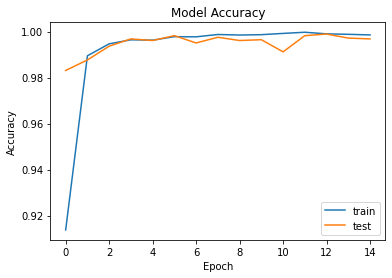

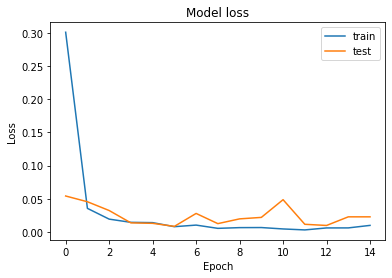

In [ ]:
import matplotlib.pyplot as plot

# print(history.history.keys())

# Accuracy
plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['train', 'test'], loc='lower right')
plot.show()
# Loss
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['train', 'test'], loc='upper right')
plot.show()